In [130]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import plotnine as gg
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
topdir="Performance"
subdir='DEC_2020'
figures = "figures"
startdate="2020-11-30"
enddate="2020-12-31"

## Directories and Filepath

In [132]:
def paths(topdir, subdir, figures):
    
    folderpath = os.path.join(Path("../", topdir), subdir)

    figpath = os.path.join(folderpath, figures)


    def create_folder(path):
             
        if not os.path.exists(path):
        
            print ("directory is created")
        
            return os.makedirs(path)
    
        else:
            
            return print ("directory is already existed")

    
    
    folder = create_folder(folderpath)

    figdir = create_folder(figpath)
    
    return folderpath, figpath


folderpath, figpath = paths(topdir, subdir, figures)
print(folderpath)
print(figpath)

directory is already existed
directory is already existed
..\Performance\DEC_2020
..\Performance\DEC_2020\figures


## Defining Paths

In [133]:
def csv_paths(folderpath):
    
    csvpath = [os.path.join(folderpath, f) for f in os.listdir(folderpath)]
    
    apriso_path = [f for f in csvpath if "Apriso" in f][0]
    
    tracker_path = [f for f in csvpath if "Tracker" in f][0]
    
    buffer_path = [f for f in csvpath if "Buffer" in f][0]
    
    return apriso_path, tracker_path, buffer_path


apriso_path, tracker_path, buffer_path = csv_paths(folderpath)

print(apriso_path)
print(tracker_path)
print(buffer_path)



..\Performance\DEC_2020\Apriso_DEC_2020.csv
..\Performance\DEC_2020\Tracker_DEC_2020.csv
..\Performance\DEC_2020\Repair_Department_Buffer_Report_DEC_2020.csv


### Creating Merged dataframe which resulted after matching Tracker and Apriso Data

In [134]:
def create_merged_csv(apriso_path, tracker_path, figpath):
    
    tracker_columns = ['DATE','RBU_SN', 'FAIL_Category', 'Fail_Group', 
                       'TRSH_NAME','STATUS', 'Notes', 'REPAIR_Person',
                       'REPAIR_NOTES', 'PRE-TRSH_Person']

    data_tracker = (pd.read_csv(tracker_path, engine='python')
                    .loc[:, tracker_columns]
                   )
    
    
    apriso_columns = ['Serial #', 'Level 1', 'Level 2', 'Level 3', 'ProductNo']
    
    data_apriso = (pd.read_csv(apriso_path)
                   .loc[:, apriso_columns]
                  )


    data_apriso['RBU_SN'] = data_apriso[data_apriso.columns[0:4]].apply(
        lambda x: ''.join(x.dropna().astype(str)),
        axis=1
    )
    
    data_apriso = (data_apriso.loc[:, ['RBU_SN', 'ProductNo']])
    
    data_tracker['DATE'] = pd.to_datetime(data_tracker['DATE'], dayfirst = True)

    data_tracker['DATE'] = data_tracker['DATE'].astype(str)
    
    data_tracker = data_tracker.loc[(data_tracker['DATE'] >= startdate) & (data_tracker['DATE'] <= enddate)]
    
    merged = data_tracker.merge(data_apriso, how='left', left_on='RBU_SN', right_on= 'RBU_SN')

    merged = merged.drop_duplicates()

        
    merged.loc[(merged['ProductNo'] == 'ROA1286713/1') & (merged['FAIL_Category'] == 'RF'), 'FAIL_Category'] = "MBFT"
    
    
    merged['RBU_SN'] = merged['RBU_SN'].str.replace("ea2a", "EA2A")
    
    
    merged['RBU_SN'] = merged['RBU_SN'].str.replace("e23", "E23")
    

    
    return merged

merged = create_merged_csv(apriso_path, tracker_path, figpath)

merged.head()

C:\Users\ekhawha\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,10,11) have mixed types.Specify dtype option on import or set low_memory=False.


,DATE,RBU_SN,FAIL_Category,Fail_Group,TRSH_NAME,STATUS,Notes,REPAIR_Person,REPAIR_NOTES,PRE-TRSH_Person,ProductNo
0,2020-11-30,EA2A108432,DIG,"SFP_EEPROM_TNB, TNB SFP EEPROM data correct",Maged Y.,PASS,NaN,NaN,NaN,NaN,NaN
1,2020-11-30,EA2A108397,DIG,"CHK_POE_01, Measure the P56V voltage at PD sim...",Maged Y.,PASS,NaN,NaN,NaN,NaN,NaN
2,2020-11-30,EA2A106555,DIG,"RU_CPRI_P0_1, Check if Sliver CPRI port 0 is Up",Maged Y.,PASS,NaN,NaN,NaN,Kazeem K.,NaN
3,2020-11-30,EA2A111770,DIG,"CHK_POE_01, Measure the P56V voltage at PD sim...",Maged Y.,PASS,NaN,Daniel S.,Passive_Comp,NaN,KRK10101/11
5,2020-11-30,EA2A109188,RF,"2.61.1.0.01, RX phase shifter characterization...",Sujin K.,OTA,PAAM failed validation test,NaN,NaN,Kazeem K.,ROA1286715/5


In [135]:
merged.DATE

0       2020-11-30
1       2020-11-30
2       2020-11-30
3       2020-11-30
5       2020-11-30
           ...    
2898    2020-12-30
2899    2020-12-30
2900    2020-12-30
2901    2020-12-30
2902    2020-12-30
Name: DATE, Length: 1733, dtype: object

# Repair department

## Functions

This function is for renaming of Failure Categories for all departments

In [136]:

def repair_dept_namechange(x):
    
    if (x['FAIL_Category'] == 'RF') | (x['FAIL_Category'] == 'DIG'):
        return "Radio"
    
    elif (x['FAIL_Category'] == 'MBFT'):
        return "MBFT"
    
    elif (x['FAIL_Category'] == 'MVI'):
        return "MVI"
    
    elif (x['FAIL_Category'] == 'SMA_Repair') | (x['FAIL_Category'] == 'SMA_REPAIR'):
        return "SMA_Repair"
    
    elif (x['FAIL_Category'] == 'ICO_TRSH'):
        return "ICO_TRSH"
    
    elif (x['FAIL_Category'] ==  'Re-work_Order'):
        return "Re-work_Order"
    
    elif (x['FAIL_Category'] ==  "Mech"):
        return "Mech"
    
    elif (x['FAIL_Category'] == 'VRT'):
        return 'VRT'
    
    
    
    
TRSH_NAME=['Bo B.','Maged Y.','Matthew T.','Mekedes W.',
           'Michael Smith U.','Omar V.','Samuel T.',
           'Sujin K.','Yohannes A.']


REPAIR_NAME=['Daniel S.','Khaliah T.','Nelson L.',
             'Rachel E.','Tamela B.','Thai L.', 'Tri N.']


PRETRSH_NAME=['Alton W.','Eric T.','Kazeem K.','Luis G.','Scott N.','Ve']


MVI_NAME=['Phat N.','Tri N.','Tuan L.']


Ist_shift = ['Bo B.','Maged Y.','Matthew T.','Michael Smith U.',
             'Sujin K.','Yohannes A.', 'Daniel S.','Khaliah T.',
             'Rachel E.', 'Alton W.','Kazeem K.','Scott N.', 
             'Phat N.','Tuan L.']


Sec_shift = ['Mekedes W.','Omar V.','Samuel T.','Nelson L.',
             'Tamela B.','Thai L.', 'Tri N.', 'Eric T.',
             'Luis G.','Ve']


   
DAYS = len(merged['DATE'].unique())


In [137]:
merged.columns

Index(['DATE', 'RBU_SN', 'FAIL_Category', 'Fail_Group', 'TRSH_NAME', 'STATUS',
       'Notes', 'REPAIR_Person', 'REPAIR_NOTES', 'PRE-TRSH_Person',
       'ProductNo'],
      dtype='object')

In [138]:

print(merged["TRSH_NAME"].unique())
print(merged["REPAIR_Person"].unique())
print(merged["PRE-TRSH_Person"].unique())




['Maged Y.' 'Sujin K.' 'Yohannes A.' nan 'Michael Smith U.' 'Samuel T.'
 'Mekedes W.' 'Omar V.' 'Bo B.' 'Matthew T.']
[nan 'Daniel S.' 'Khaliah T.' 'Thai L.' 'Tamela B.' 'Rachel E.'
 'Nelson L.' 'daniel s']
[nan 'Kazeem K.' 'Alton W.' 'Scott N.' 'Phat N.' 'Luis G.' 'Ve' 'Eric T.'
 'Tri N.' 'Tuan L.' 'phat n.']


## TRSH Performance and KPI

C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Performance\DEC_2020\figures\Trouble_shooters_performance_DEC_2020.png
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Performance\DEC_2020\figures\Trouble_shooters_KPI.png


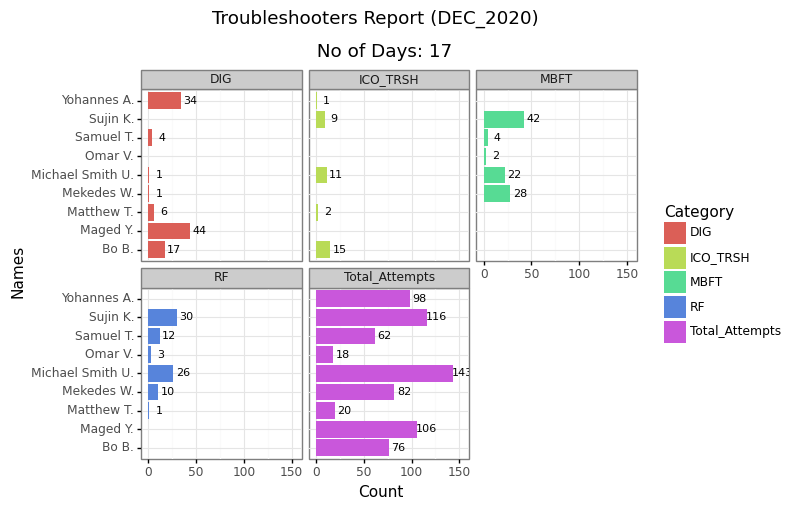

<ggplot: (125986408057)>


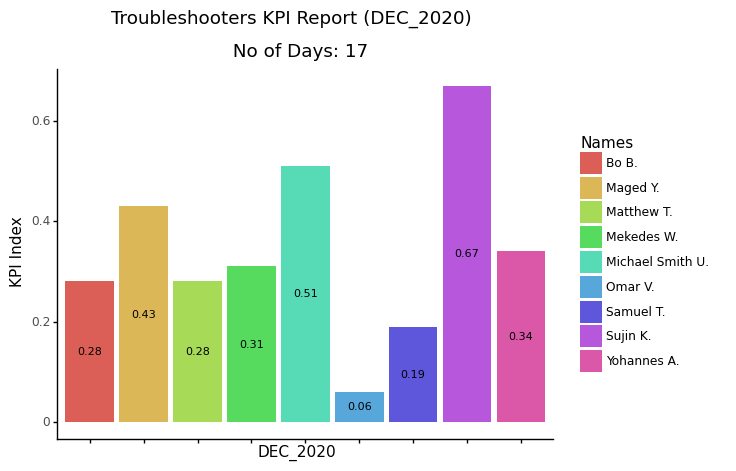

<ggplot: (125993650098)>


,Names,Category,Count
0,Bo B.,DIG,17
1,Bo B.,ICO_TRSH,15
2,Maged Y.,DIG,44
3,Matthew T.,DIG,6
4,Matthew T.,ICO_TRSH,2
5,Matthew T.,RF,1
6,Mekedes W.,DIG,1
7,Mekedes W.,MBFT,28
8,Mekedes W.,RF,10
9,Michael Smith U.,DIG,1


In [139]:
def TRSH_Performance_KPI(merged, TRSH_NAME, figpath, DAYS):
    
    tmp = merged.copy()
    

    def ICO_condition(x):
        if x["FAIL_Category"] == 'ICO_TRSH':
            return 'ICO_TRSH'

        else:
            return x['ProductNo']



    cat_condition=["DIG", "RF", "MBFT", "ICO_TRSH"]


    tmp['ProductNo'] = tmp.apply(ICO_condition, axis=1) # assigning ICO_TRSH in ProductNo column if FAIL_Category column contains "ICO_TRSH"


    tmp_df = (tmp.query('FAIL_Category in @ cat_condition and TRSH_NAME in @ TRSH_NAME')
                 .drop_duplicates(subset=["RBU_SN"], keep='last')  ## drop duplicate units and keeping the last row with unique unit
                 .dropna(subset=['ProductNo'])      ## droping na values based on ProductNo column
                 .groupby(['TRSH_NAME',"FAIL_Category"])
                 .count()
                 .reset_index()
                .loc[:, ['TRSH_NAME','FAIL_Category' ,'DATE']]
                .rename(columns={'TRSH_NAME': 'Names',
                                 'FAIL_Category': "Category",
                                 'DATE': "Count",
                                })

                )


    total = (merged.groupby('TRSH_NAME').count()
                .reset_index()
                .loc[:, ['TRSH_NAME','DATE']]
                .rename(columns={'TRSH_NAME': 'Names',
                                 'DATE': "Count",
                                })
                )


    total['Category'] = 'Total_Attempts'

    total = total.loc[:, ['Names', 'Category', 'Count']]

    fn = (tmp_df.append(total)
          .reset_index()
          .drop(columns='index')
         )

    p = gg.ggplot(fn, gg.aes(x='Names', y='Count',fill="Category", label='Count')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_bw() + \
        gg.coord_flip() + \
        gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                 size=8, nudge_x=0, nudge_y=10, show_legend=True) + \
        gg.labs(title= 'Troubleshooters Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))



    p = p + gg.facet_wrap('~ Category', nrow=2)



    gg.ggsave(filename='Trouble_shooters_performance_' + str(subdir) +'.png', plot = p, path = figpath)


    ## Calculating TRSH KPI



    #min_threshold_radio=25
    target_radio= 6 * DAYS    ## 65 min / radio



    #min_threshold_board=25
    target_board= 8 * DAYS       ## 50 min / board



    def repair_dept_kpi(x):

        if (x['Category'] == 'RF') | (x['Category'] == 'DIG'):
            return "Radio"

        elif (x['Category'] == 'MBFT') | (x['Category'] == "ICO_TRSH"):
            return "Board"




    def KPI_radio(x):

        if (x['Category'] == "Radio") & (x['Names'] == 'Matthew T.'):

            k = (x['Count']) / (0.3 * target_radio)

            return k

        elif (x['Category'] == "Radio") & (x['Names'] == 'Omar V.'):

            k = (x['Count']) / (0.75 * target_radio)

            return k 

        elif (x['Category'] == "Radio"):

            k = (x['Count']) / (target_radio)

            return k 


    def KPI_board(x):

        if (x['Category'] == "Board") & (x['Names'] == 'Matthew T.'):

            k = (x['Count']) / (0.3 * target_board)

            return k 

        elif (x['Category'] == "Board") & (x['Names'] == 'Omar V.'):

            k = (x['Count'])  / (0.75 * target_board)

            return k 

        elif (x['Category'] == "Board"):

            k = (x['Count']) / (target_board)

            return k



    kpi = tmp_df.copy()



    kpi['Category'] = kpi.apply(repair_dept_kpi, axis=1)




    kpi = (kpi.groupby(["Names", "Category"])
               .sum()
               .reset_index()

              )



    kpi['KPI_Radio'] = kpi.apply(KPI_radio, axis=1)



    kpi['KPI_board'] = kpi.apply(KPI_board, axis=1)





    kpi = (kpi.groupby("Names")
               .sum()
               .reset_index()
               .assign(Total_Kpi = lambda x: np.round(x['KPI_Radio'] + x['KPI_board'], 2))
              )




    g = gg.ggplot(kpi, gg.aes(x='Names', y='Total_Kpi',fill="Names", label='Total_Kpi')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'Troubleshooters KPI Report'+ ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS),
                x=str(subdir),
                y="KPI Index"
               ) + \
        gg.theme(axis_text_x=gg.element_blank())


    gg.ggsave(filename='Trouble_shooters_KPI.png', plot = g, path = figpath)


    return tmp_df, p, g



TRSH_data, TRSH_fig_1, TRSH_fig_2 = TRSH_Performance_KPI(merged, TRSH_NAME,figpath, DAYS)

print(TRSH_fig_1)
print(TRSH_fig_2)
      
TRSH_data

### Pre-TRSH performance and KPI

C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Performance\DEC_2020\figures\Pre_Trouble_shooters_performance_DEC_2020.png
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Performance\DEC_2020\figures\Pre-Trouble_shooters_KPI_DEC_2020.png


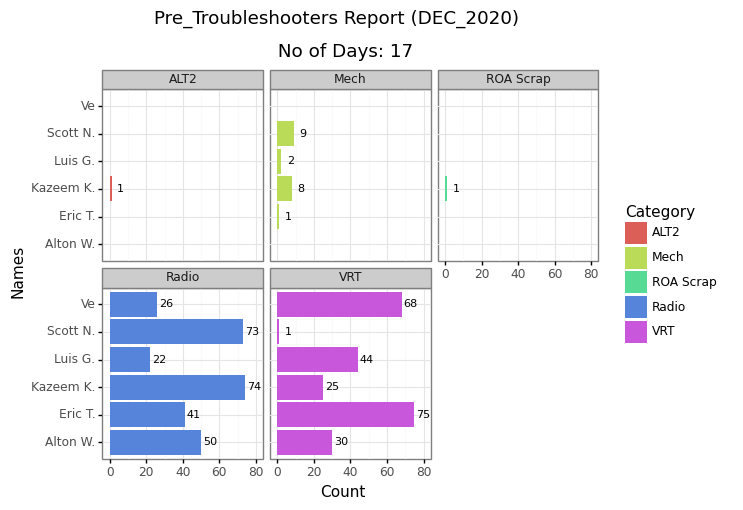

<ggplot: (125986333862)>


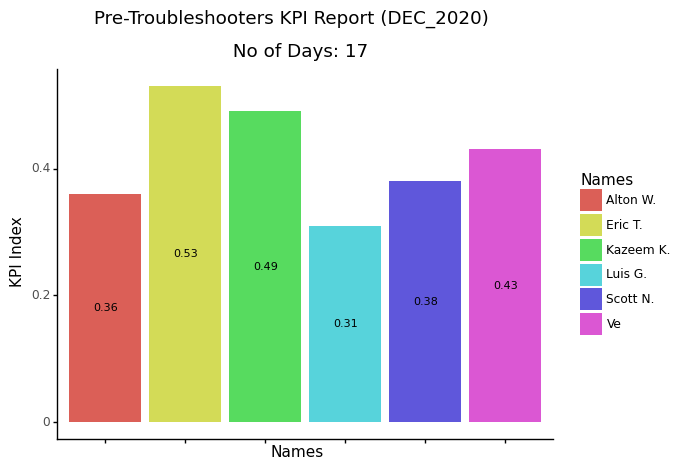

<ggplot: (125995025917)>


In [140]:
def pre_TRSH_Performance_KPI(merged, figpath, PRETRSH_NAME, DAYS):
    
    
    def repair_dept_pre_TRSH(x):


        if (x['FAIL_Category'] == 'RF') | (x['FAIL_Category'] == 'DIG'):
            return "Radio"

        elif (x['FAIL_Category'] ==  'Re-work_Order'):
            return "Re-work_Order"

        elif (x['FAIL_Category'] == "Mech") & (x['STATUS'] == "ALT2"):
            return "ALT2"

        elif (x['FAIL_Category'] == "Mech") & (x['STATUS'] != "ALT2"):
            return "Mech"

        elif (x['STATUS'] == "Pre-Scrap"):
            return "ROA Scrap"

        elif (x['FAIL_Category'] == 'VRT'):
            return 'VRT'


        
# ## Calling RF and DIG. as Radio and count twice for similar person   
    

    tmp = merged.copy()


    tmp['Category'] = tmp.apply(repair_dept_pre_TRSH, axis=1)



    pre_TRSH_categories = ['Radio', 'VRT', 'ALT2', 'Re-work_Order',
           'Mech', 'ROA Scrap']





    tmp = (tmp[tmp['Category'].isin(pre_TRSH_categories) &  
              tmp['PRE-TRSH_Person'].isin(PRETRSH_NAME)]
          )


    tmp1 = tmp.drop_duplicates(['RBU_SN', 'PRE-TRSH_Person', 'Category'], keep='last')



    pre_TRSH = (tmp1.groupby(['PRE-TRSH_Person','Category'])
    .count()
    .reset_index()
    .loc[:, ['PRE-TRSH_Person','Category', 'DATE']]
    .rename(columns={'PRE-TRSH_Person': 'Names',
                    'FAIL_Category':"Category",
                    'DATE': "Count"})

          )



    pre = gg.ggplot(pre_TRSH, gg.aes(x='Names', y='Count',fill="Category", label='Count')) + \
            gg.geom_col(stat="identity") + \
            gg.theme_bw() + \
            gg.coord_flip() + \
            gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                     size=8, nudge_x=0, nudge_y=5, show_legend=True) + \
            gg.labs(title= 'Pre_Troubleshooters Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))



    pre = pre + gg.facet_wrap('~ Category', nrow=2)


    gg.ggsave(filename='Pre_Trouble_shooters_performance_' + str(subdir) +'.png', plot = pre, path = figpath)






    # min_threshold_radio=55
    # min_threshold_rework=30

    y  = 13 * DAYS  #(Radio=Mech.=Validation_test=65 min)

    target_Radio=13 * DAYS   ## 35 min / radio 
    target_Mech=13 * DAYS    ## 35 min / Mech.
    target_ALT2= 8 * DAYS    ## 25 min / ALT2
    target_Rework=8 * DAYS  ## 60 min / Rework
    target_VRT=13 * DAYS     ## 35 min / VRT




    def KPI_preTRSH(x):

        if (x['Category'] == "Radio") | (x['Category'] == 'Mech') | (x['Category'] == 'VRT') :

            k = (x['Count']) / y

            return k

        elif x['Category'] == 'ALT2':

            k = (x['Count']) / target_ALT2

            return k

        elif x['Category'] == 'Re-work_Order':

            k = (x['Count']) / target_Rework

            return k




    KPI_PTRSH = pre_TRSH.copy()



    KPI_PTRSH['KPI_Pre-TRSH'] = KPI_PTRSH.apply(KPI_preTRSH, axis=1)





    KPI_PTRSH = (KPI_PTRSH.groupby("Names")
           .sum()
           .reset_index()
           .loc[:, ['Names','Count', 'KPI_Pre-TRSH']]


          )

    KPI_PTRSH['KPI_Pre-TRSH'] = np.round(KPI_PTRSH['KPI_Pre-TRSH'], 2)


    g = gg.ggplot(KPI_PTRSH, gg.aes(x='Names', y='KPI_Pre-TRSH',fill="Names", label='KPI_Pre-TRSH')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'Pre-Troubleshooters KPI Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS) ,
                x='Names',
                y="KPI Index"
               ) + \
        gg.theme(axis_text_x=gg.element_blank())




    gg.ggsave(filename='Pre-Trouble_shooters_KPI_'+ str(subdir) + '.png', plot = g, path = figpath)
    
    


    return pre_TRSH, pre, g, tmp1


pre_TRSH, pre_TRSH_fig_1, pre_TRSH_fig_2, RDpt_lg = pre_TRSH_Performance_KPI(merged, figpath,PRETRSH_NAME, DAYS)  # RDpt_lg is used to generate repair department line graph

print(pre_TRSH_fig_1)
print(pre_TRSH_fig_2)

#tmp1.to_csv("test3.csv")

## MVI Performance and KPI

<ipython-input-141-7f9fc98a3ca9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Performance\DEC_2020\figures\MVI_performance_modified_DEC_2020.png
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Performance\DEC_2020\figures\KPI_MVI_DEC_2020.png


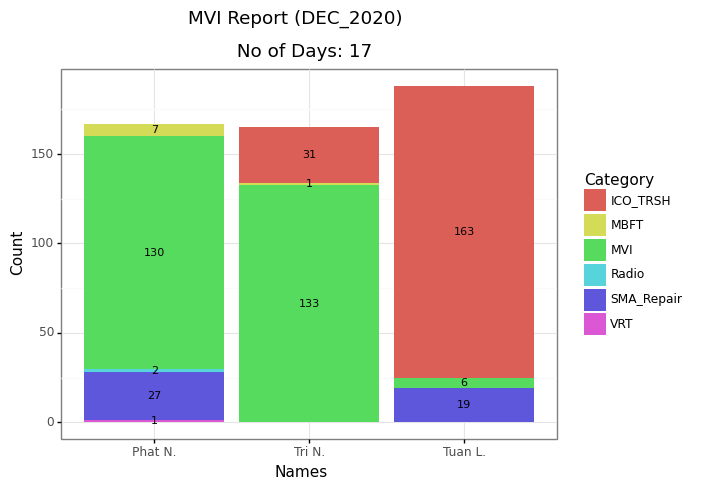

<ggplot: (125994148042)>


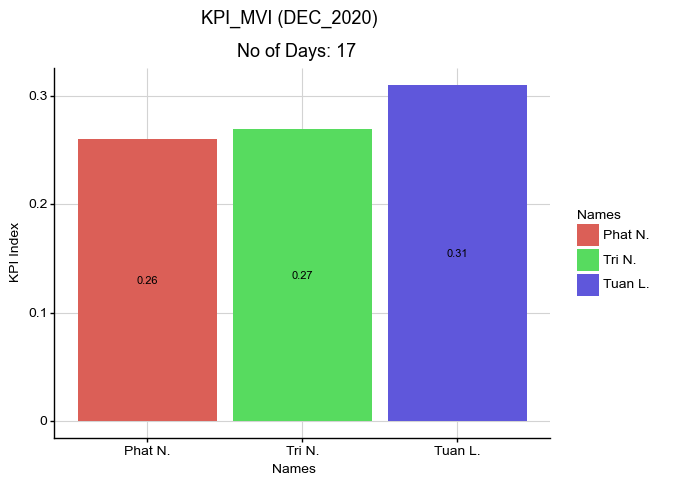

<ggplot: (125987338457)>


In [141]:
def MVI_Performance_KPI(merged, figpath, MVI_NAME, DAYS):
    
    
    def repair_dept_namechange(x):

        if (x['FAIL_Category'] == 'RF') | (x['FAIL_Category'] == 'DIG'):
            return "Radio"

        elif (x['FAIL_Category'] == 'MBFT'):
            return "MBFT"

        elif (x['FAIL_Category'] == 'MVI'):
            return "MVI"

        elif (x['FAIL_Category'] == 'SMA_Repair') | (x['FAIL_Category'] == 'SMA REPAIR'):
            return "SMA_Repair"

        elif (x['FAIL_Category'] == 'ICO_TRSH'):
            return "ICO_TRSH"

        elif (x['FAIL_Category'] ==  'Re-work_Order'):
            return "Re-work_Order"

        elif (x['FAIL_Category'] ==  "Mech"):
            return "Mech"

        elif (x['FAIL_Category'] == 'VRT'):
            return 'VRT'
    
    


    mvi = merged[merged['PRE-TRSH_Person'].isin(MVI_NAME)]


    mvi['FAIL_Category'] = mvi.apply(repair_dept_namechange, axis=1)





    mvi = (mvi.groupby(['PRE-TRSH_Person',"FAIL_Category"])
           .count()
           .reset_index()
           .loc[:, ['PRE-TRSH_Person','FAIL_Category', 'DATE']]
           .rename(columns={'PRE-TRSH_Person': 'Names',
                                   'FAIL_Category':"Category",
                                   'DATE': "Count"})

                 )


    mvi_plot = gg.ggplot(mvi, gg.aes(x='Names', y='Count', fill="Category", label='Count')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_bw() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'MVI Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))






    gg.ggsave(filename='MVI_performance_modified_'+ str(subdir) + '.png', plot = mvi_plot, path = figpath)
    
    
    
    
    #min_threshold_board_mvi=170
    
    target_board_mvi=36 * DAYS  # 12 min /board




    def mvi_kpi(x):

        if (x['Category'] == 'MVI') | (x['Category'] == 'SMA_Repair') | (x['Category'] == 'ICO_TRSH'):
            return "board_mvi"



    def KPI_MVI(x):

        if (x['Category'] == "board_mvi"):

            k = (x['Count'])/ (target_board_mvi)

            return np.round(k, 2)


    
        
    KPI_mvi = mvi.copy()


    KPI_mvi['Category'] = KPI_mvi.apply(mvi_kpi, axis=1)


    KPI_mvi = (KPI_mvi.groupby(["Names", "Category"])
           .sum()
           .reset_index()

          )


    KPI_mvi['KPI_MVI'] = KPI_mvi.apply(KPI_MVI, axis=1)






    mvi_kpi = gg.ggplot(KPI_mvi, gg.aes(x='Names', y='KPI_MVI',fill="Names", label='KPI_MVI')) + \
        gg.geom_col(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'KPI_MVI' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS),
                x='Names',
                y="KPI Index"
               ) + \
        gg.theme(
        axis_line=gg.element_line(size=1, colour="black"),
        panel_grid_major=gg.element_line(colour="#d3d3d3"),
        panel_grid_minor=gg.element_blank(),
        panel_border=gg.element_blank(),
        panel_background=gg.element_blank(),
        plot_title=gg.element_text(size=13, family="Arial"),
        text=gg.element_text(family="Arial", size=10),
        axis_text_x=gg.element_text(colour="black", size=10),
        axis_text_y=gg.element_text(colour="black", size=10)
    )




    gg.ggsave(filename='KPI_MVI_'+ str(subdir) + '.png', plot = mvi_kpi, path = figpath)
    
    return mvi, mvi_plot, mvi_kpi





mvi_data, mvi_fig1, mvi_fig2 = MVI_Performance_KPI(merged, figpath, MVI_NAME, DAYS)

print(mvi_fig1)
print(mvi_fig2)

## Soldering Performance and KPI

<ipython-input-142-36b12409739c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Performance\DEC_2020\figures\soldering_performanceDEC_2020.png
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\ekhawha\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: ..\Performance\DEC_2020\figures\soldering_KPIDEC_2020.png


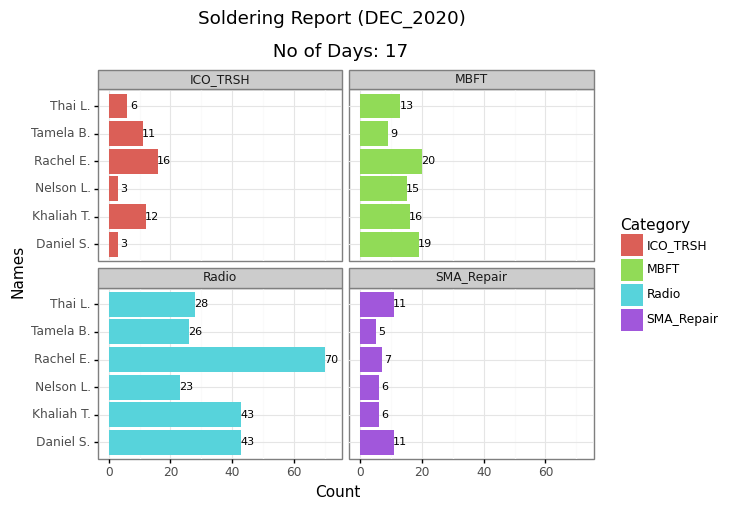

<ggplot: (125986393715)>


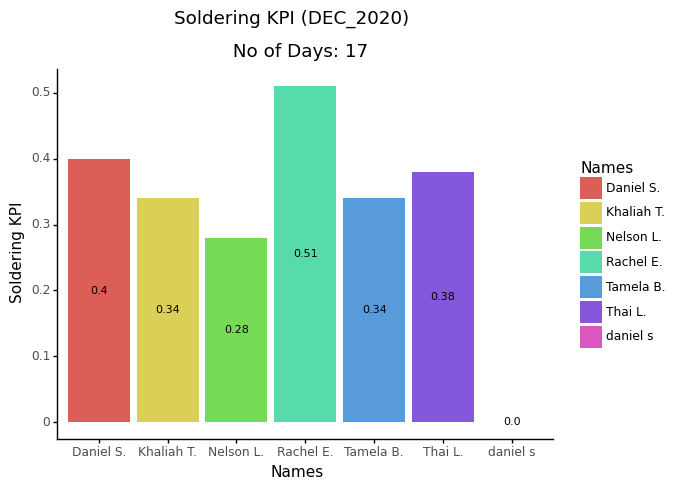

<ggplot: (125994475798)>


In [142]:
def soldering_Performance_KPI(merged, figpath, REPAIR_NAME, DAYS):
    
      
    def repairsoldering_dept_namechange(x):

        if (x['FAIL_Category'] == 'RF') | (x['FAIL_Category'] == 'DIG'):
            return "Radio"

        elif (x['FAIL_Category'] == 'SMA_Repair') | (x['FAIL_Category'] == 'SMA REPAIR'):
            return "SMA_Repair"

        elif (x['FAIL_Category'] == 'ICO_TRSH'):
            return "ICO_TRSH"

        elif (x['FAIL_Category'] ==  "MBFT"):
            return "MBFT"




    repair = merged[merged['REPAIR_Person'].isin(REPAIR_NAME)]

    repair['FAIL_Category'] = (repair
                               .apply(repairsoldering_dept_namechange, axis=1)
                              )


    repair = (repair
              .drop_duplicates(['RBU_SN',"FAIL_Category",'REPAIR_Person', 'REPAIR_NOTES'], keep='last')
             )




    repair = (repair.groupby(['FAIL_Category','REPAIR_Person'])
              .count()
              .reset_index()
              .loc[:, ['FAIL_Category', 'REPAIR_Person','DATE']]
              .rename(columns={'REPAIR_Person': 'Names',
                                   'FAIL_Category':"Category",
                                   'DATE': "Count"})
              .loc[:, ['Names', 'Category', 'Count']]
              
             )



    soldering_plot = gg.ggplot(repair, gg.aes(x='Names', y='Count', fill="Category", label='Count')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_bw() + \
        gg.coord_flip() + \
        gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                     size=8, nudge_x=0, nudge_y=2, show_legend=True) + \
        gg.labs(title= 'Soldering Report' + ' (' + str(subdir) + ')  \n\n No of Days: ' + str(DAYS))



    soldering_plot = soldering_plot + gg.facet_wrap('~ Category', nrow=2)






    gg.ggsave(filename='soldering_performance' + str(subdir) + '.png', plot = soldering_plot, path = figpath)


    # ## Calculating Soldering KPI



    soldering_categories=['Passive_Comp', '1_IC', '2_IC', 
                          'Connector', 'Pre-Scrap','3_IC']


    target_connector = 15 * DAYS     ## 30min per connector
    target_2_3IC = 6.4 * DAYS         ## 70min per 2_IC or 3_IC
    target_1IC_Passive = 18 * DAYS   ## 25min per 1_IC or Passive Comp.


    def kpi_soldering(x):

        if x['Category'] == 'Connector':

            k = (x['Count']) / target_connector

            return k

        elif (x['Category'] == '2_IC') | (x['Category'] == '3_IC'):

            k = (x['Count']) / target_2_3IC

            return k


        elif (x['Category'] == '1_IC') | (x['Category'] == 'Passive_Comp'):

            k = (x['Count']) / target_1IC_Passive

            return k





    soldering_KPI = (merged
                     .groupby(['REPAIR_Person', 'REPAIR_NOTES'])
                     .count()
                     .reset_index()
                     .loc[:, ['REPAIR_Person', 'REPAIR_NOTES', 'DATE']]
                     .rename(columns={'REPAIR_Person': 'Names',
                                     'REPAIR_NOTES': 'Category',
                                     'DATE': 'Count'})
                     
                    )



    soldering_KPI['Soldering KPI'] = soldering_KPI.apply(kpi_soldering, axis=1)

    soldering_KPI = (soldering_KPI.groupby('Names')
                    .sum()
                    .reset_index()
                    )



    soldering_KPI['Soldering KPI'] = np.round(soldering_KPI['Soldering KPI'], 2)


    soldering_kpi = gg.ggplot(soldering_KPI, gg.aes(x='Names', y='Soldering KPI', fill='Names', label='Soldering KPI')) + \
        gg.geom_bar(stat="identity") + \
        gg.theme_classic() + \
        gg.geom_text(position=gg.position_stack(vjust=0.5), size = 8) + \
        gg.labs(title= 'Soldering KPI'+ ' (' + str(subdir) +')  \n\n No of Days: ' + str(DAYS))






    gg.ggsave(filename='soldering_KPI' + str(subdir) + '.png', plot = soldering_kpi, path = figpath)



    
    return repair, soldering_plot, soldering_kpi


repair_data, repair_fig1, repair_fig2 = soldering_Performance_KPI(merged, figpath, REPAIR_NAME, DAYS)

print(repair_fig1)
print(repair_fig2)


## Repair Department Report

<AxesSubplot:title={'center':'Repair Department Report (DEC_2020)'}>

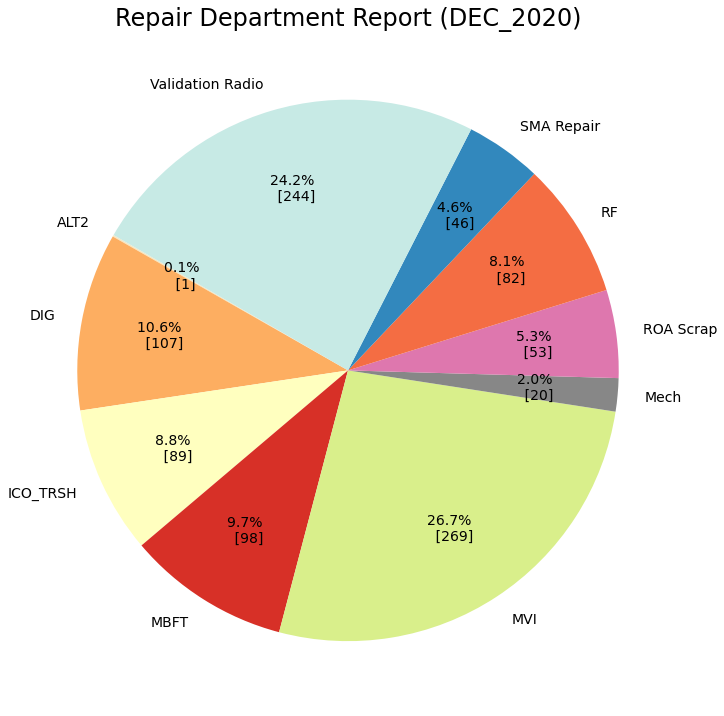

In [143]:

def repair_department_report(merged, TRSH_data, pre_TRSH, mvi_data, repair_data, figpath):



    mvi_truncated = ['MVI', 'VRT']
    
    mvi_data = (mvi_data.query("Category in @ mvi_truncated")
                .iloc[:, 1:]
               )

    repair_truncated = ['ICO_TRSH', 'SMA_Repair']

    repair_data = (repair_data.query("Category in @ repair_truncated")
                   .iloc[:, 1:]
                  )

    pre_TRSH_truncated = ['Mech','VRT', 'ALT2', 'Re-work_Order']

    pre_TRSH_data = (pre_TRSH.query("Category in @ pre_TRSH_truncated")
                   .iloc[:, 1:]
                  )

    TRSH_data = TRSH_data.iloc[:, 1:3]
    
    
    prescrap = (merged.query("STATUS == 'Pre-Scrap'")
            .drop_duplicates('RBU_SN', keep='last')
            .groupby('STATUS')
            .count()
            .reset_index()
            .iloc[:, 0:2]
            .rename(columns={'STATUS': 'Category',
                             'DATE': 'Count'})


           )


    
    final_data = (pd.concat([TRSH_data, pre_TRSH_data, mvi_data, repair_data, prescrap])
              .groupby('Category')
              .sum()
              .reset_index()
              .groupby('Category')
              .sum()
              .reset_index()
              .replace(['Pre-Scrap', 'Re-work_Order', 'SMA_Repair', 'VRT'],
                       ['ROA Scrap', 'Re-Work', 'SMA Repair', 'Validation Radio'])
             )

 ## plotting pie chart
    
    
    plt.rcParams['font.size'] = 20


    labels = final_data['Category'].unique()

    values = final_data['Count'].values



    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(np.round(pct*total/100.0))
            return '{p:.1f}% \n [{v:d}]'.format(p=pct,v=val)
        return my_autopct


    mapping_colors = {'ALT2': '#f6e8c3',
                     'DIG': '#fdae61',
                     'ICO_TRSH': '#ffffbf',
                     'MBFT': '#d73027',
                     'MVI': '#d9ef8b',
                     'Mech': '#878787',
                     'RF': '#f46d43',
                     'ROA Scrap': '#de77ae',
                     'Re-Work': '#e0e0e0',
                     'SMA Repair': '#3288bd',
                     'Validation Radio': '#c7eae5'}



    fig, ax = plt.subplots(figsize=(20, 10))
    ax.pie(values,labels=labels, colors = [mapping_colors[key] for key in labels], autopct=make_autopct(values),
            shadow=False, startangle=150, pctdistance=0.7, textprops={'color':"k", 
                                                                      'fontsize': 14}, 
           rotatelabels=False)


    # Equal aspect ratio ensures that pie is drawn as a circle

    plt.tight_layout()

    plt.title('Repair Department Report' + ' (' + str(subdir) + ')')


    plt.savefig(os.path.join(figpath, 'piechart_Repair Department Weekly report_' + str(subdir) +'.png'), bbox_inches='tight')          
  
    
    return ax


repair_department_report(merged, TRSH_data, pre_TRSH, mvi_data, repair_data, figpath)


<ipython-input-144-05eaefe83d1b>:115: UserWarning: FixedFormatter should only be used together with FixedLocator


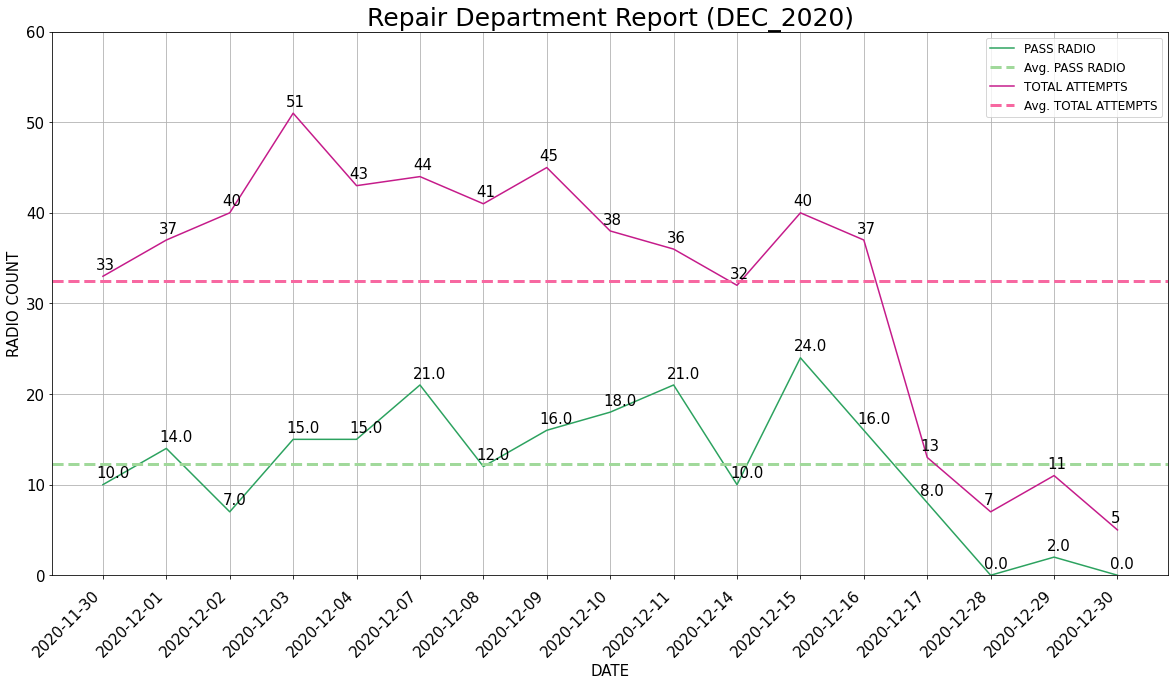

(<AxesSubplot:title={'center':'Repair Department Report (DEC_2020)'}, xlabel='DATE', ylabel='RADIO COUNT'>,
     index        DATE  Count_Radio
 0       0  2020-11-30           10
 1       1  2020-12-01           14
 2       2  2020-12-02            7
 3       3  2020-12-03           15
 4       4  2020-12-04           15
 5       5  2020-12-07           21
 6       6  2020-12-08           12
 7       7  2020-12-09           16
 8       8  2020-12-10           18
 9       9  2020-12-11           21
 10     10  2020-12-14           10
 11     11  2020-12-15           24
 12     12  2020-12-16           16
 13     13  2020-12-17            8
 14     14  2020-12-29            2)

In [144]:
def radio_report(merged, figpath):
    
    
    tmp = merged.copy()
    




    radios=["RF", "DIG", 'Mech', 'Re-work_Order']




    tmp = (tmp.query('FAIL_Category in @ radios')
                 .drop_duplicates(subset=["RBU_SN"], keep='last')  ## drop duplicate units and keeping the last row with unique unit
                 .dropna(subset=['ProductNo'])      ## droping na values based on ProductNo column
                 .groupby('DATE')
                 .count()
                 .reset_index()
                .loc[:, ['DATE','RBU_SN']]
                .rename(columns={
                                 'RBU_SN': "Count_Radio",
                                })

                )


# tmp_df
    
#     tmp = (merged[merged['ProductNo'].str.contains('KRK*', na=False)]
#     .dropna(subset=['ProductNo']) 
#     .drop_duplicates(subset=["RBU_SN"], keep='last')
#     .groupby(['DATE',"FAIL_Category"])
#     .count()
#     .reset_index()
#     .groupby('DATE')
#     .sum()
#     .reset_index()
#     .loc[:, ['DATE','RBU_SN']]
#     .rename(columns={'RBU_SN': "Count_Radio"})

#    )


    




    tmp1 = (merged[merged['FAIL_Category'].isin(radios)]
            .groupby(['DATE','RBU_SN'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','FAIL_Category']]
            .rename(columns={'FAIL_Category': "Count_Total"})

          )


    tmp = tmp.sort_values(by='DATE',ascending=True).reset_index()



    tmp1 = tmp1.sort_values(by='DATE',ascending=True).reset_index()



    tpp = (pd.merge(tmp1, tmp, on=["DATE", "DATE"], how='outer')
           .fillna(value=0)
          )



    average_tmp = np.average(tpp['Count_Radio'])

    average_tmp1 = np.average(tpp['Count_Total'])


    from matplotlib.ticker import MaxNLocator
    plt.rcParams.update({'font.size': 15})



    fig, ax = plt.subplots(figsize=(20, 10))


    x = np.array(tpp['DATE'])
    y = np.array(tpp['Count_Radio'])

    y1 = np.array(tmp1['Count_Total'])

    values = list(tpp['Count_Radio'])
    values1 = list(tpp['Count_Total'])

    plt.xlabel('DATE')
    plt.ylabel('RADIO COUNT')


    plt.title('Repair Department Report'+ ' (' + str(subdir) + ')', fontsize=25)

    ax.plot(x, y, color='#2ca25f', linestyle='solid', label='PASS RADIO')

    ax.axhline(average_tmp, color="#a1d99b", linestyle='dashed', linewidth=3)

    ax.plot(x, y1, color='#c51b8a', linestyle='solid', label='TOTAL ATTEMPTS')

    ax.axhline(average_tmp1, color="#f768a1", linestyle='dashed', linewidth=3)

    dates_label = merged.DATE.unique().tolist()

    ax.set_xticklabels(dates_label, rotation = 45, ha="right", position=(0,-0.01))



    for i, v in enumerate(values):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    for i, v in enumerate(values1):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    plt.ylim(0, 60)

    plt.legend(['PASS RADIO', 'Avg. PASS RADIO','TOTAL ATTEMPTS', 'Avg. TOTAL ATTEMPTS'], fontsize=12)

    plt.grid()
    plt.show()

    fig.savefig(os.path.join(figpath, "Repair_department_weekly_report_Radio_" + str(subdir) +'.png'))


    
    return ax, tmp

radio_report(merged, figpath)

<ipython-input-145-15e88d4c1f32>:90: UserWarning: FixedFormatter should only be used together with FixedLocator


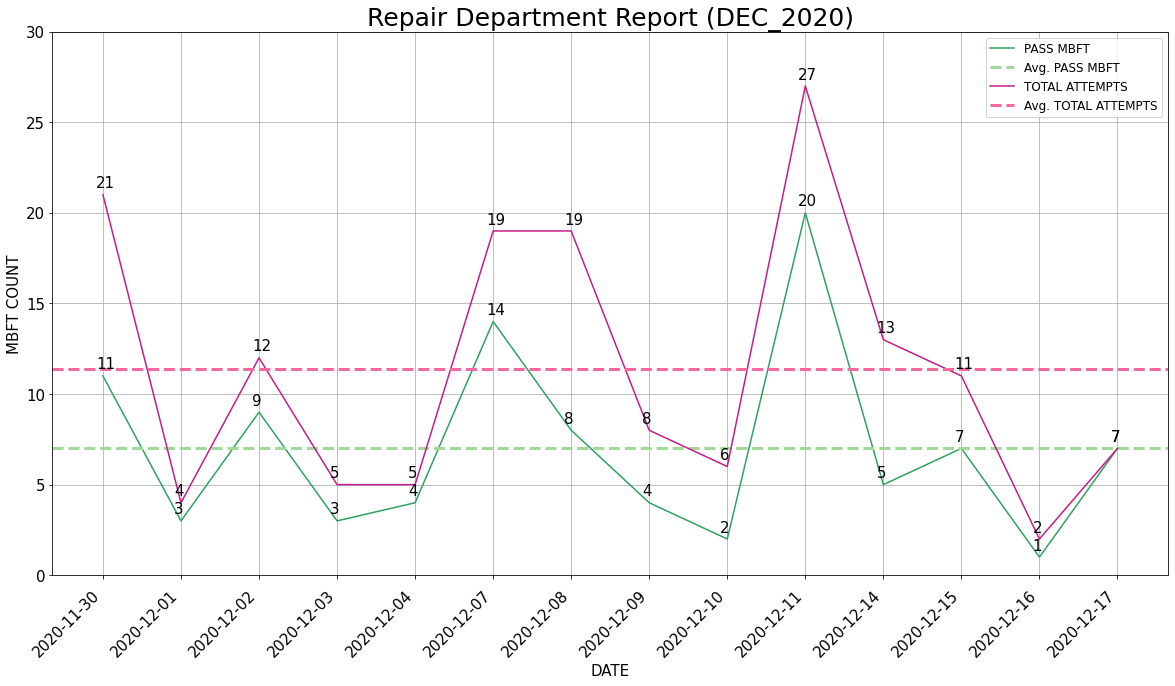

<AxesSubplot:title={'center':'Repair Department Report (DEC_2020)'}, xlabel='DATE', ylabel='MBFT COUNT'>

In [145]:
def mbft_report(merged, figpath):
    
    
    radios=['MBFT']
    
    
    tmp = (merged.query('FAIL_Category in @ radios')
             .drop_duplicates(subset=["RBU_SN"], keep='last')  ## drop duplicate units and keeping the last row with unique unit
             .dropna(subset=['ProductNo'])      ## Note: droping na values based on ProductNo column which means all the unit which couldn't pass are excluded
             .groupby(['DATE', "FAIL_Category"])
             .count()
             .reset_index()
             .loc[:, ['DATE','RBU_SN']]
             .rename(columns={'RBU_SN': 'Count'
                            })

            )




    tmp1 = (merged.query('FAIL_Category in @ radios')
            .groupby(['DATE','RBU_SN'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','FAIL_Category']]
            .rename(columns={'FAIL_Category': "Count"})

          )

  


    tmp['DATE'] = pd.to_datetime(tmp['DATE'], dayfirst = True)

    tmp = tmp.sort_values(by='DATE',ascending=True).reset_index()

    tmp['DATE'] = tmp['DATE'].astype(str)


    tmp1['DATE'] = pd.to_datetime(tmp1['DATE'], dayfirst = True)

    tmp1 = tmp1.sort_values(by='DATE',ascending=True).reset_index()

    tmp1['DATE'] = tmp1['DATE'].astype(str)


    average_tmp = np.average(tmp['Count'])

    average_tmp1 = np.average(tmp1['Count'])



    from matplotlib.ticker import MaxNLocator

    plt.rcParams.update({'font.size': 15})
    #plt.rcParams["figure.figsize"] = [20,9]


    fig, ax = plt.subplots(figsize=(20, 10))

    #fig.yaxis.set_major_locator(MaxNLocator(integer=True))

    x = np.array(tmp['DATE'])
    y = np.array(tmp['Count'])

    y1 = np.array(tmp1['Count'])

    values = list(tmp1['Count'])
    values1 = list(tmp['Count'])

    plt.xlabel('DATE')
    plt.ylabel('MBFT COUNT')


    plt.title('Repair Department Report' + ' (' + str(subdir) + ')', fontsize=25)

    ax.plot(x, y, color='#2ca25f', linestyle='solid', label='PASS MBFT')
    ax.axhline(average_tmp, color="#a1d99b", linestyle='dashed', linewidth=3)

    ax.plot(x, y1, color='#c51b8a', linestyle='solid', label='TOTAL ATTEMPTS')

    ax.axhline(average_tmp1, color="#f768a1", linestyle='dashed', linewidth=3)
    
    dates_label = merged.DATE.unique().tolist()
    
    ax.set_xticklabels(dates_label, rotation = 45, ha="right", position=(0,-0.01))



    for i, v in enumerate(values):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    for i, v in enumerate(values1):
        plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')

    plt.ylim(0, 30)

    plt.legend(['PASS MBFT', 'Avg. PASS MBFT','TOTAL ATTEMPTS', 'Avg. TOTAL ATTEMPTS'], fontsize=12)

    plt.grid()
    plt.show()


    fig.savefig(os.path.join(figpath, "Repair_department_weekly_report_MBFT_" + str(subdir) +'.png'))
    
    
    return ax

mbft_report(merged, figpath)
    

### Loading Data & Running function for creating buffer report

<AxesSubplot:title={'center':'Repair Department Buffer Report (DEC_2020)'}, xlabel='DATE', ylabel='BUFFER REPORT'>

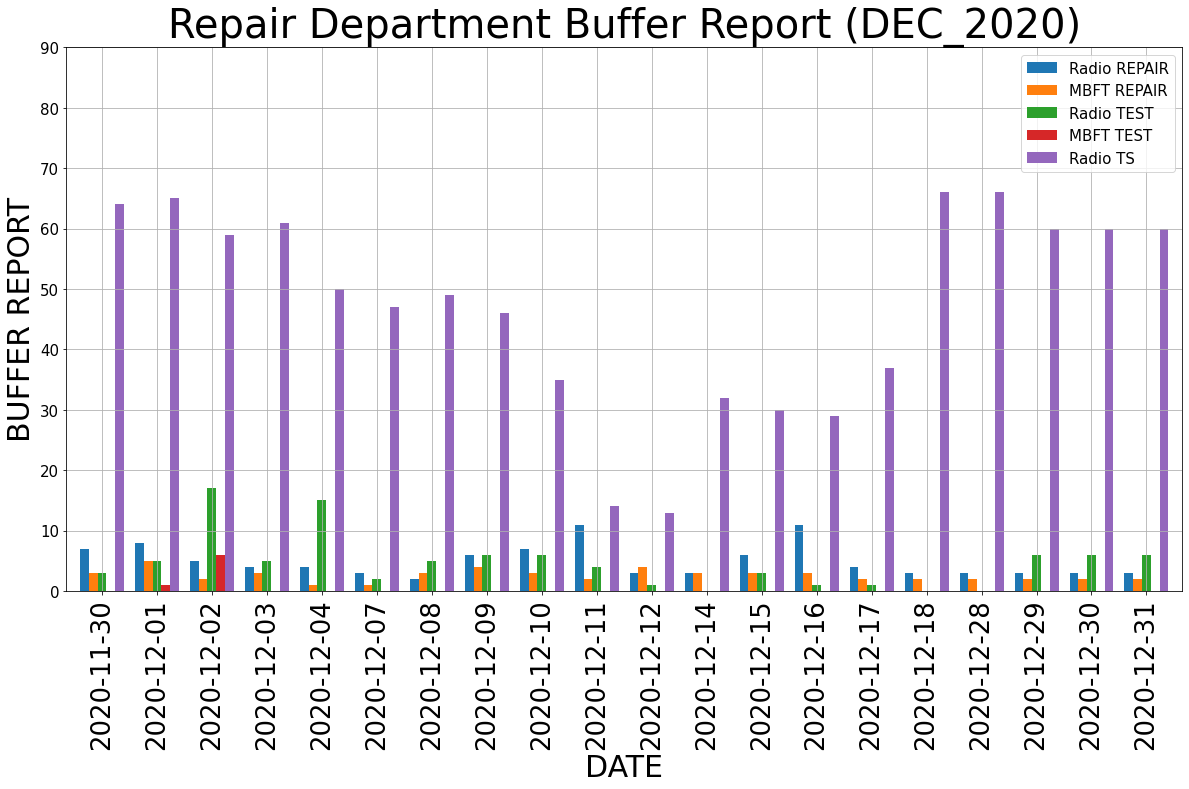

In [146]:
def buffer_figure(path, figpath):
    
    
    ''' path: path of data file
    
        figpath: path of saving figures
        
    '''
    data_buffer = pd.read_csv(path)
    
    
    ### Data preprocessing and converting DATE FORMAT and changed it string Format

    data_buffer['DATE'] = pd.to_datetime(data_buffer['DATE'], dayfirst = True)

    data_buffer['DATE'] = data_buffer['DATE'].astype(str)
    
    ### Plotting Figure
    
    
    plt.rcParams["figure.figsize"] = [20, 10]

    ax = data_buffer.plot.bar(x='DATE', y=list(data_buffer.columns[2:7]), width=0.8)

    plt.xlabel('DATE', fontsize=30)

    plt.ylabel('BUFFER REPORT', fontsize=30)

    ax.xaxis.set_tick_params(labelsize='xx-large')

    plt.title('Repair Department Buffer Report' + ' (' + str(subdir) + ')', fontsize=40)

    plt.legend(fontsize=15)

    plt.grid()

    plt.yticks(np.arange(0, 100, 10))

    plt.savefig(os.path.join(figpath, 'REPAIR DEPARTMENT BUFFER REPORT_' + str(subdir) +'.png'), bbox_inches='tight')
    
    
    return ax




buffer_figure(buffer_path, figpath)


